# understanding embeddings: retrieval augmented generation demo
## rutgers ieee ml/ai workshop by mehek 🐙

week 1 of natural language processing track

february 11, 2026




# install packages

In [ ]:
!pip install faiss-cpu pypdf sentence-transformers openai -q

# openai key + load sentence transformer model from hugging face

if you want to rerun this notebook, you will need your own openai api key. this will be used for the chatbot interaction

for the embeddings of our pdf chunks, we are able to use any embedding model we want to since we will be doing the retrieving / storing through a vector database ourselves


In [ ]:
from sentence_transformers import SentenceTransformer
from openai import OpenAI
import faiss
import numpy as np
from pypdf import PdfReader
from google.colab import files

client = OpenAI(api_key="INSERT-API-KEY-HERE")
model = SentenceTransformer("all-MiniLM-L6-v2")  # fast model to load

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


# extract text from pdf

In [ ]:
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]
reader = PdfReader(pdf_path)

text = ""
for page in reader.pages:
    text += page.extract_text() + "\n"

print("Loaded PDF:", pdf_path)
print("Total characters:", len(text))

Saving attention_yay.pdf to attention_yay.pdf
Loaded PDF: attention_yay.pdf
Total characters: 39630


# chunk pdf into pieces

In [ ]:
def chunk_text(text, chunk_size=500, overlap=100):
  # try changing the chunk_size !
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk)
        start += chunk_size - overlap
    return chunks

chunks = chunk_text(text)
len(chunks)

100

# create embeddings for pdf chunks
since there is only one pdf that has been loaded, the number of embedding vectors that will be stored in the database is equivalent to the number of chunks we have

(1 chunk --> encoded into 1 embedding vector)


In [ ]:
embeddings = model.encode(chunks)
print("Number of embedding vectors:", embeddings.shape)
dimension = embeddings.shape[1]
print("Embedding dimension:", dimension)

Number of embedding vectors: (100, 384)
Embedding dimension: 384


# create vector database & store embeddings


FAISS = Facebook AI Similarity Search
- open source library for finding similarities between high-dimensional vectors
- returns k nearest neighbor

IndexFlat2 measures L2 (Euclidean) distance between all given points of a query vector and the vectors loaded into the index.

In [ ]:
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings).astype("float32"))
print("FAISS index size:", index.ntotal)

FAISS index size: 100


# we can visualize our vector database
we have to use a method called PCA to represent the database as in a 2D format since the vectors are very high dimensional (384 dimension embeddings)

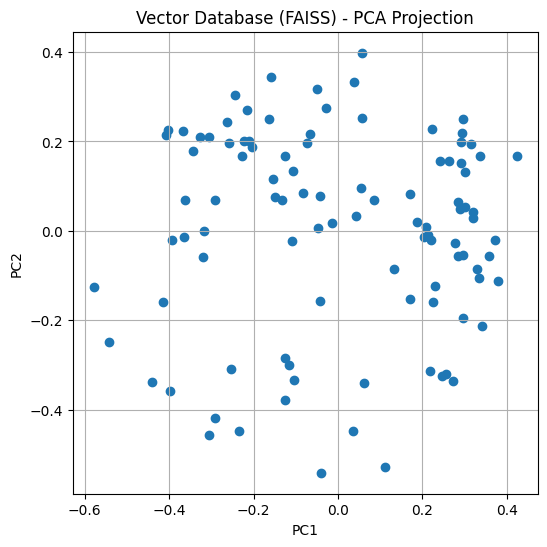

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# convert FAISS index to numpy
faiss_vectors = index.reconstruct_n(0, index.ntotal)

# reduce to 2D
pca = PCA(n_components=2)
points_2d = pca.fit_transform(faiss_vectors)

# plot the points yayyy
plt.figure(figsize=(6,6))
plt.scatter(points_2d[:,0], points_2d[:,1])
plt.title("Vector Database (FAISS) - PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


# retrieval function
we encode the query into an embedding vector and do a search for vectors in the database that are most similar to the query embedding vectors. we return the PDF chunks of text that correspond to the most similar k number of vectors.

*we have to use the same exact embedding model that we used for the PDF chunks to be able to search in the vector database for information that is similar/relevant to the query*


In [ ]:
def retrieve(query, k=3):
    q_emb = model.encode([query])
    distances, indices = index.search(np.array(q_emb).astype("float32"), k)
    return [chunks[i] for i in indices[0]]

In [ ]:
def answer_question_with_RAG(query):
    retrieved = retrieve(query, k=3)
    context = "\n\n---\n\n".join(retrieved)

    prompt = f"""
    You are a helpful assistant. Use ONLY the context below to answer.

    Question: {query}

    Context:
    {context}

    If the answer is not in the context, say "Not found in the document."
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    print("🔍 Retrieved Chunks:\n")
    for c in retrieved:
        print("----\n", c[:300], "...\n")

    print("\n🤖 Answer:\n")
    print(response.choices[0].message.content)


In [ ]:
def answer_question_without_RAG(query):
    prompt = f"""
    You are a helpful assistant. Use ONLY the context below to answer.

    Question: {query}"
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    print("🤖 Answer:\n")
    print(response.choices[0].message.content)


# try a query!
we can see which PDF chunks were relevant to the query and provide that information to the chatbot (ChatGPT) along with the original query text.

the final answer is what the chatbot outputs after having the extra knowledge that we provided

In [ ]:
answer_question_with_RAG("What are the main topics covered?")

🔍 Retrieved Chunks:

----
 Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.
Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Par ...

----
 anjan Das, and Jakob Uszkoreit. A decomposable attention
model. In Empirical Methods in Natural Language Processing , 2016.
[28] Romain Paulus, Caiming Xiong, and Richard Socher. A deep reinforced model for abstractive
summarization. arXiv preprint arXiv:1705.04304, 2017.
[29] Slav Petrov, Leon Barr ...

----
 cribed in section 3.2.
Self-attention, sometimes called intra-attention is an attention mechanism relating different positions
of a single sequence in order to compute a representation of the sequence. Self-attention has been
used successfully in a variety of tasks including reading comprehension, a ...


🤖 Answer:

The main topics covered include

# we can look visualize the results of the retrieval
again, we have to use a technique called PCA to represent the database in a 2D format since the raw vectors are very high dimensional

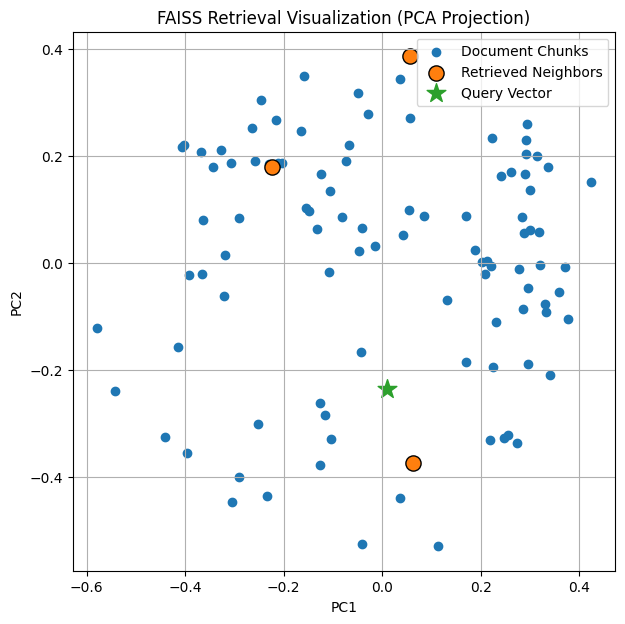

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_retrieval(query, k=3):
    # embed query
    q_vec = model.encode([query]).astype("float32")

    # FAISS search
    distances, indices = index.search(q_vec, k)
    neighbors = indices[0]

    # reconstruct stored vectors
    faiss_vectors = index.reconstruct_n(0, index.ntotal)

    # stack query vector with stored vectors
    all_vecs = np.vstack([faiss_vectors, q_vec])

    # reduce to 2D
    pca = PCA(n_components=2)
    all_2d = pca.fit_transform(all_vecs)
    vecs_2d = all_2d[:-1]
    query_2d = all_2d[-1]

    plt.figure(figsize=(7,7))

    # plot all vectors (from the database)
    plt.scatter(vecs_2d[:,0], vecs_2d[:,1], label="Document Chunks")

    # highlight retrieved ones
    plt.scatter(vecs_2d[neighbors,0], vecs_2d[neighbors,1],
                s=120, edgecolor='black', label="Retrieved Neighbors")

    # plot the query vector :D
    plt.scatter(query_2d[0], query_2d[1],
                s=200, marker="*", label="Query Vector")

    plt.title("FAISS Retrieval Visualization (PCA Projection)")
    plt.legend()
    plt.grid(True)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

visualize_retrieval("What are the main topics?")

# query without performing RAG

In [ ]:
answer_question_without_RAG("What are the main topics covered?")

🤖 Answer:

I'm sorry, but I don't have any context provided to answer your question. Could you please provide the relevant information or context?
